
# Normal, Ledoit-Wolf and OAS Linear Discriminant Analysis for classification

This example illustrates how the Ledoit-Wolf and Oracle Approximating
Shrinkage (OAS) estimators of covariance can improve classification.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.covariance import OAS
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_train = 20  # samples for training
n_test = 200  # samples for testing
n_averages = 50  # how often to repeat classification
n_features_max = 75  # maximum number of features
step = 4  # step size for the calculation


In [2]:


def generate_data(n_samples, n_features):
    """Generate random blob-ish data with noisy features.

    This returns an array of input data with shape `(n_samples, n_features)`
    and an array of `n_samples` target labels.

    Only one feature contains discriminative information, the other features
    contain only noise.
    """
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])

    # add non-discriminative features
    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features - 1)])
    return X, y



### Linear Discriminant Analysis (LDA) for Two Classes

Linear Discriminant Analysis (LDA) is a classification method used to predict the class $\ y $ of a sample given an observation $\ \vec{x} $. The goal is to find a predictor that can determine the class $\ y $ of any sample, given only the observation $\ \vec{x} $.

#### Assumptions and Bayes' Optimal Solution

LDA assumes that the conditional probability density functions $\ p(\vec{x} | y = 0) $ and $\ p(\vec{x} | y = 1) $ are both normal distributions with mean and covariance parameters $\ (\vec{\mu}_0, \Sigma_0)$ and $\ (\vec{\mu}_1, \Sigma_1) $, respectively. Under this assumption, the Bayes-optimal solution is to predict points as being from the second class if the log of the likelihood ratios is bigger than some threshold $\ T $, so that:

$\
\frac{1}{2} (\vec{x} - \vec{\mu}_0)^T \Sigma_0^{-1} (\vec{x} - \vec{\mu}_0) + \frac{1}{2} \ln |\Sigma_0| - \frac{1}{2} (\vec{x} - \vec{\mu}_1)^T \Sigma_1^{-1} (\vec{x} - \vec{\mu}_1) - \frac{1}{2} \ln |\Sigma_1| > T
$

Without any further assumptions, the resulting classifier is referred to as quadratic discriminant analysis (QDA).

#### Homoscedasticity Assumption

LDA makes the simplifying homoscedasticity assumption (i.e., that the class covariances are identical, so $\ \Sigma_0 = \Sigma_1 = \Sigma $) and that the covariances have full rank. In this case, several terms cancel:

$\
\vec{x}^T \Sigma_0^{-1} \vec{x} = \vec{x}^T \Sigma_1^{-1} \vec{x}
$

$\
\vec{x}^T \Sigma_i^{-1} \vec{\mu}_i = \vec{\mu}_i^T \Sigma_i^{-1} \vec{x} \text{ because } \Sigma_i \text{ is Hermitian}
$

and the above decision criterion becomes a threshold on the dot product:

$\
\vec{w}^T \vec{x} > c
$

for some threshold constant $\ c $, where

$\
\vec{w} = \Sigma^{-1} (\vec{\mu}_1 - \vec{\mu}_0)
$

$\
c = \frac{1}{2} \vec{\mu}_1^T \Sigma^{-1} \vec{\mu}_1 + \frac{1}{2} \vec{\mu}_0^T \Sigma^{-1} \vec{\mu}_0
$

This means that the criterion of an input $\ \vec{x} $ being in a class $\ y $ is purely a function of this linear combination of the known observations.

#### Geometric Interpretation

The criterion of an input $\ \vec{x} $ being in a class $\ y $ is purely a function of the projection of multidimensional-space point $\ \vec{x} $ onto vector $\ \vec{w} $. In other words, the observation belongs to $\ y $ if corresponding $\ \vec{x} $ is located on a certain side of a hyperplane perpendicular to $\ \vec{w} $. The location of the plane is defined by the threshold $\ c $.

### Sklearn Implementation of LDA: Argument Specifications

#### Solver

- **Description**: Specifies the algorithm to use for the LDA.
- **Options**:
  - `'svd'`: Singular value decomposition (default). This solver is recommended for data with a large number of features.
  - `'lsqr'`: Least squares solution. This solver is faster than 'eigen' for large datasets.
  - `'eigen'`: Eigenvalue decomposition. This solver can be useful if the classes are very well-separated.

#### Shrinkage

- **Description**: Shrinkage parameter for covariance estimation.
- **Options**:
  - `None`: No shrinkage applied (default).
  - `'auto'`: Automatically computes the shrinkage coefficient.
  - `float`: Manual setting of the shrinkage coefficient between 0 and 1.

#### Priors

- **Description**: The class prior probabilities.
- **Options**:
  - `None`: The class priors are determined from the training data (default).
  - `array-like`: User-specified class prior probabilities.

#### n_components

- **Description**: Number of components (< min(n_classes - 1, n_features)) for dimensionality reduction.
- **Default**: `None`, which means all components are used.

#### Store_covariance

- **Description**: If True, the covariance matrices are computed and stored.
- **Default**: `False`.

#### tol

- **Description**: Tolerance to decide if a covariance matrix is singular.
- **Default**: `1.0e-4`.

#### Example Usage in Sklearn

```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=1.0e-4)


### Oracle Approximating Shrinkage (OAS)

Oracle Approximating Shrinkage (OAS) is a method used in statistical learning to estimate the covariance matrix of a dataset. It aims to improve the stability and accuracy of the covariance matrix estimate, especially when the number of observations is small compared to the number of features.

#### Mathematical Background

In high-dimensional settings, the sample covariance matrix can be unstable and may not invert well. Shrinkage methods improve the condition of the covariance matrix by combining the sample covariance matrix $\ S $ with a structured estimator $\ F $ (often the identity matrix or a diagonal matrix). The general form of a shrinkage estimator $\ \hat{\Sigma} $ is:

$\
\hat{\Sigma} = (1 - \lambda)S + \lambda F
$

where $\ \lambda $ is the shrinkage coefficient. The OAS method determines the optimal value of $\ \lambda $ by minimizing the mean squared error between the estimated covariance matrix and the true covariance matrix.

The shrinkage target $\ F $ in OAS is typically chosen to be the scaled identity matrix:

$\
F = \frac{\text{tr}(S)}{p} I
$
The optimal shrinkage coefficient $\ \lambda $ in OAS is derived analytically to minimize the mean squared error between $\ \hat{\Sigma} $ and $\ \Sigma $. The OAS shrinkage coefficient is given by:

$\
\lambda = \frac{(1 - 2/p) \text{trace}(S^2) + \text{trace}(S)^2}{(n + 1 - 2/p) \text{trace}(S^2) + (n - 1) \text{trace}(S)^2}
$

This formula ensures that the shrinkage intensity is adjusted according to the sample size and dimensionality, providing an optimal balance between bias and variance.

#### Sklearn Implementation of OAS: Argument Specifications

#### store_precision

- **Description**: If True, the estimated precision (inverse covariance) matrix is stored.
- **Default**: `False`.

#### assume_centered

- **Description**: If True, the data is considered to be centered (mean is zero). If False, the mean of the data is subtracted before computing the covariance.
- **Default**: `False`.

#### Detailed Explanation

- **store_precision**: Storing the precision matrix can be useful for certain applications, such as inverse covariance-based feature selection. However, it can increase memory usage.
  
- **assume_centered**: Assuming the data is centered can save computation time if you know in advance that the data has zero mean. If the data is not centered and this parameter is set to True, the results will be incorrect.


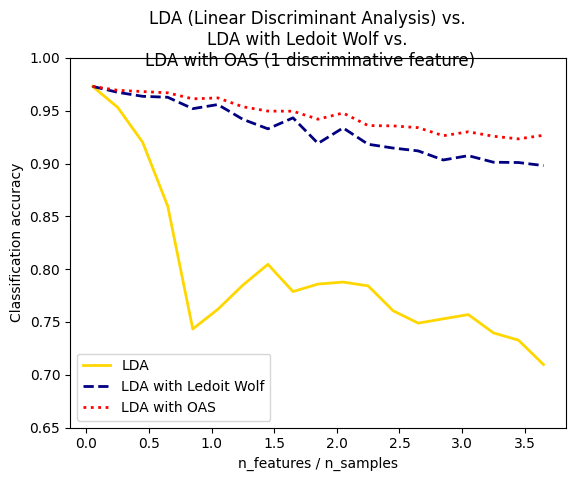

In [5]:

acc_clf1, acc_clf2, acc_clf3 = [], [], []
n_features_range = range(1, n_features_max + 1, step)
for n_features in n_features_range:
    score_clf1, score_clf2, score_clf3 = 0, 0, 0
    for _ in range(n_averages):
        X, y = generate_data(n_train, n_features)

        clf1 = LinearDiscriminantAnalysis(solver="lsqr", shrinkage=None).fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto").fit(X, y)
        oa = OAS(store_precision=False, assume_centered=False)
        clf3 = LinearDiscriminantAnalysis(solver="lsqr", covariance_estimator=oa).fit(
            X, y
        )

        X, y = generate_data(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)
        score_clf3 += clf3.score(X, y)

    acc_clf1.append(score_clf1 / n_averages)
    acc_clf2.append(score_clf2 / n_averages)
    acc_clf3.append(score_clf3 / n_averages)

features_samples_ratio = np.array(n_features_range) / n_train

plt.plot(
    features_samples_ratio,
    acc_clf1,
    linewidth=2,
    label="LDA",
    color="gold",
    linestyle="solid",
)
plt.plot(
    features_samples_ratio,
    acc_clf2,
    linewidth=2,
    label="LDA with Ledoit Wolf",
    color="navy",
    linestyle="dashed",
)
plt.plot(
    features_samples_ratio,
    acc_clf3,
    linewidth=2,
    label="LDA with OAS",
    color="red",
    linestyle="dotted",
)

plt.xlabel("n_features / n_samples")
plt.ylabel("Classification accuracy")

plt.legend(loc="lower left")
plt.ylim((0.65, 1.0))
plt.suptitle(
    "LDA (Linear Discriminant Analysis) vs. "
    + "\n"
    + "LDA with Ledoit Wolf vs. "
    + "\n"
    + "LDA with OAS (1 discriminative feature)"
)
plt.show()